In [1]:
import numpy as np
import os
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters, exposure

In [2]:
try:
    from shapes import *
    from detect_bubbles import *
    from utils import *
except ImportError:
    print("Import warning")
    pass

Import warning


In [3]:
from classify_bubble import *
from bubbleNet1D import *

/Users/Habib/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def init_figure(frameon=False, figsize=(6,6)):
    fig = plt.figure(frameon, figsize)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

In [6]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [7]:
def show_bubble_circle(image, circ, color="red"):
    fig1 = plt.figure(figsize=(8,8))
    ax1 = fig1.add_subplot(111, aspect='equal')
    plt.imshow(image, cmap="gray")
    ax1.add_patch(
                patches.Circle(
                    (circ.y, circ.x),   
                    circ.radius,
                    fill=False,
                    color=color))

In [8]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [9]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [10]:
cim = []
bgim = []
for file in filenames[1:]:
    if file.endswith(".bmp"):
        if int(file[-5:-4])%2 ==0:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            cim.append(img)
        else:
            img = cv2.imread(os.path.join(calib_dir, file), 0)
            bgim.append(img)

## The algorithm -> Radius calibration -> green radius

In [11]:
green_bubble =  bgim[0][75:135, 675:730]

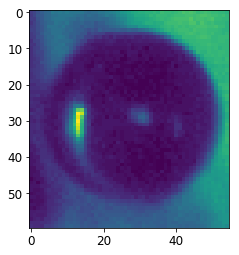

In [12]:
plt.imshow(green_bubble)

In [13]:
edges = filters.sobel(green_bubble)

In [14]:
edges_profile = np.loadtxt("../thesis/extern/edges_profile.csv", skiprows=1, delimiter=",")

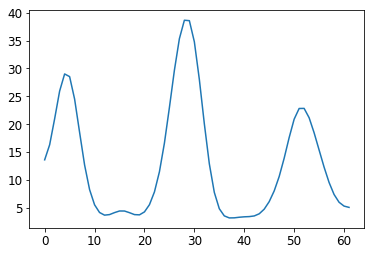

In [15]:
from scipy.ndimage.filters import gaussian_filter1d
ydata = gaussian_filter1d(edges_profile.T[1], sigma=2)
plt.plot(ydata)

In [16]:
xdata = np.arange(0, len(ydata))

In [17]:
def gauss(x, a, mu, sigma):
    return a * np.exp(- (x - mu)**2/sigma**2)

In [18]:
popt1, _ = curve_fit(gauss, xdata, ydata, p0=[30, 5, 2])
popt2, _ = curve_fit(gauss, xdata, ydata, p0=[30, 56, 2])

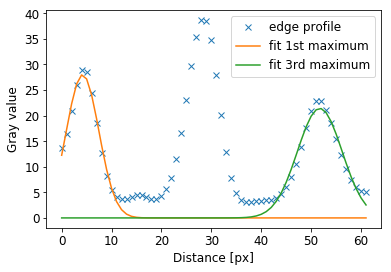

In [19]:
fig = plt.figure(frameon=False)
fig.set_size_inches(6,4)
plt.plot(ydata, 'x', label="edge profile")
plt.plot(xdata, gauss(xdata, *popt1), label="fit 1st maximum")
plt.plot(xdata, gauss(xdata, *popt2), label="fit 3rd maximum")
plt.xlabel("Distance [px]")
plt.ylabel("Gray value")
plt.legend()
#plt.savefig("../thesis/graphs/green_radius_demo.png")

# The algorithm -> radius calibration -> factor

In [20]:
# data from radius_calibration.ipynb

red_radii = []
green_radii = []

red_radii.append( [15.5, 15, 16, 16, 15.5, 16])
green_radii.append( [19.35, 20.05, 20.02, 20.09])

red_radii.append( [7, 7.5, 6, 7.5, 7.5, 7, 7.5, 6.5] )
green_radii.append( [12.09, 11.22, 12.07, 11.02])

red_radii.append([11.5, 11, 11.5])
green_radii.append( [14.07, 14.87, 15] )

red_radii.append([9, 9.5, 9.5, 9, 9.5, 10])
green_radii.append([13.06, 13.93, 14.01] )



In [21]:
x_data = [np.mean(r) for r in red_radii]
y_data = [np.mean(g) for g in green_radii]
y_err = [np.std(r) for r in red_radii]
x_err = [np.std(g) for g in green_radii]

In [22]:
def lin(x, a, b):
    return a*x +b

In [23]:
popt_lin, _ = curve_fit(lin, x_data, y_data)

In [24]:
popt_lin

array([ 0.95690246,  4.54637797])

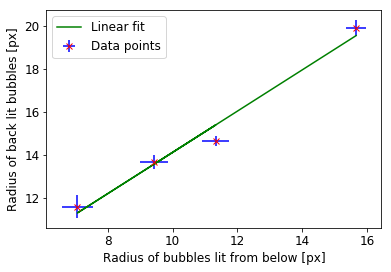

In [25]:
plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='rx', ecolor='b', label="Data points")
plt.plot(x_data, lin(np.asarray(x_data), *popt_lin), 'g', label="Linear fit")
plt.xlabel("Radius of bubbles lit from below [px]")
plt.ylabel("Radius of back lit bubbles [px]")
plt.legend()
#plt.savefig("../thesis/graphs/radius_calibration_result.png")

# 2.2.4 Edges and Derivation

In [26]:
red_bubb = transform.rotate(cim[0][580:630, 500:550], 90)

In [27]:
gb = np.flip(green_bubble.T, axis=0)

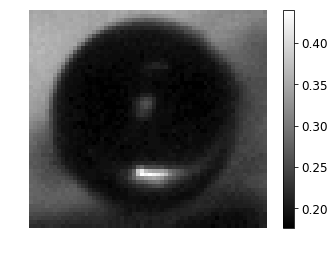

In [28]:
plt.imshow(gb/255, cmap="gray")
_ = plt.axis('off')
plt.colorbar()
#plt.savefig("../thesis/images/green_one.png")

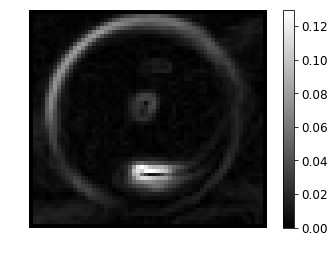

In [29]:
plt.imshow(filters.sobel( gb/255), cmap="gray")
_ = plt.axis('off')
plt.colorbar()
#plt.savefig("../thesis/images/green_one_sobel.png")

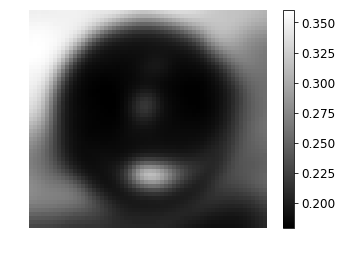

In [30]:
plt.imshow(filters.gaussian(gb, sigma=2), cmap="gray")
_ = plt.axis('off')
plt.colorbar()
#plt.savefig("../thesis/images/green_one_gaussian.png")

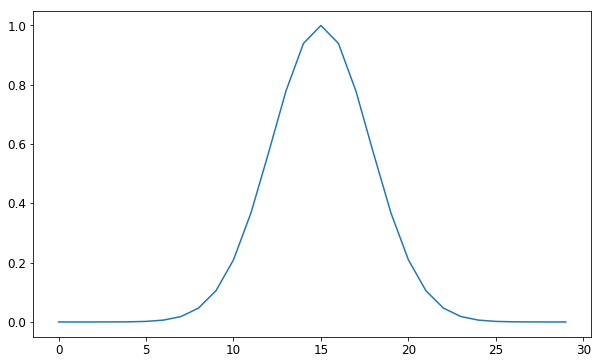

In [31]:
xx = np.arange(0, 30)
yy = gauss(x=xx, a=1, sigma=4, mu=15)
plt.figure(figsize=(10,6))
plt.plot(yy)
#plt.savefig("../thesis/graphs/gauss_sigma_4.png")

# 2.2.5 Orientation and structure tensor

In [32]:
mess_small = [cv2.imread( os.path.join("data", filename), 0) for filename in os.listdir("data") if filename.endswith("png")]

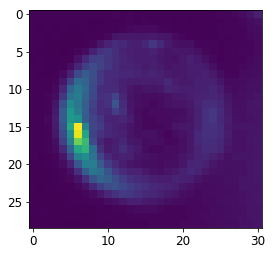

In [59]:
im = mess_small[3]
plt.imshow(im)

In [60]:
import utils

In [61]:
size = 31
xx = np.linspace(0,10, size)
yy = np.linspace(0,10, size)
XX, YY = np.meshgrid(xx, yy)
smooth_mask = utils.gauss_2d_mask([XX,YY], amp=10, mu=[5,5], sigma=[1,1])

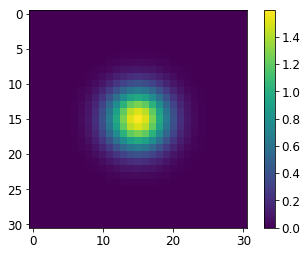

In [62]:
plt.imshow(smooth_mask)
plt.colorbar()

In [63]:
Axx, Axy, Ayy = utils.my_structure_tensor(im, smooth_mask)

In [64]:
gamma_adjusted = exposure.adjust_gamma(im, 0.1)
gamma_adjusted = np.flip(gamma_adjusted.T, axis=0)
Axx, Axy, Ayy = utils.my_structure_tensor(gamma_adjusted, smooth_mask)

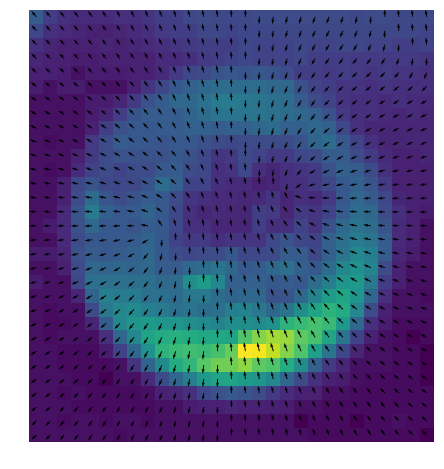

In [65]:
fig = plt.figure(frameon=False, figsize=(6,6))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

n, m = Axx.shape 
X, Y = np.mgrid[0:n, 0:m]
T = .5 * np.arctan2(2 * Axy, Ayy-Axx)
R = np.ones((gamma_adjusted.shape)) * gamma_adjusted
U, V = R * (-np.cos(T)), R * (np.sin(T))
_ = plt.quiver(U, V, linewidths=2)
_ = plt.imshow(gamma_adjusted)
#plt.savefig("../thesis/images/structure_tensor_demo.png")

# 2.3 Object detection problem

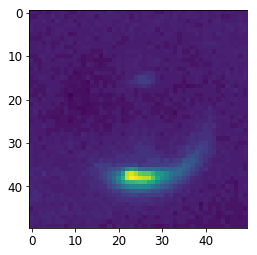

In [66]:
plt.imshow(red_bubb)

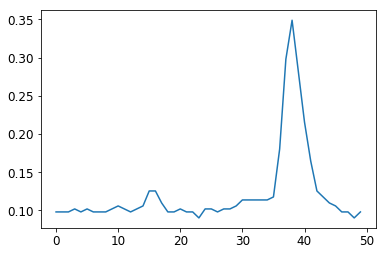

In [67]:
plt.plot(red_bubb[:,25])
#plt.savefig("../thesis/graphs/red_profile_1.png")

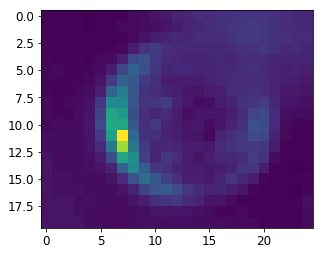

In [68]:
plt.imshow(mess_small[4])

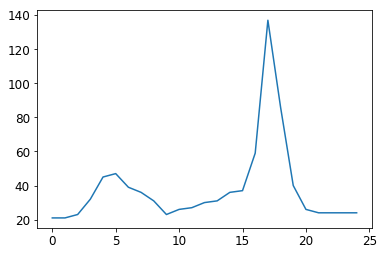

In [69]:
plt.plot(np.flip(mess_small[4][11,:], axis=0))
#plt.savefig("../thesis/graphs/red_profile_2.png")

In [70]:
one_peaks = cv2.imread("../thesis/images/one_peaks.png", 0)

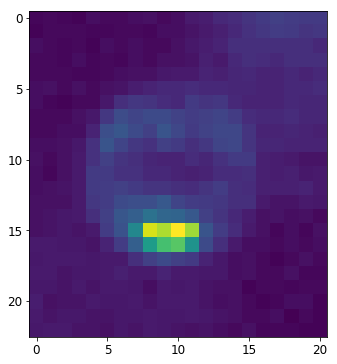

In [71]:
plt.figure(figsize=(6,6))
plt.imshow(one_peaks)
#plt.savefig("../thesis/images/one_peaks_color.png")

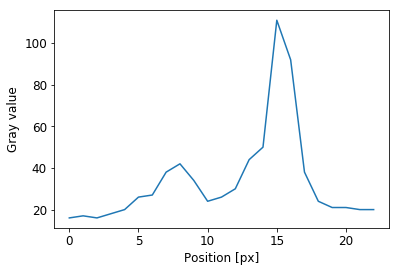

In [72]:
plt.figure(figsize=(6,4))
plt.plot(one_peaks[:,9])
plt.xlabel("Position [px]")
plt.ylabel("Gray value")
#plt.savefig("../thesis/graphs/one_peaks_profile.png")

# 5.3.2 Radius from orientation

In [73]:
one = cv2.imread("data/one_mess.png", 0)

In [74]:
Axx, Axy, Ayy = utils.my_structure_tensor(one, smooth_mask)

In [75]:
gamma_adjusted = exposure.adjust_gamma(one, 1)
gamma_adjusted = np.flip(gamma_adjusted.T, axis=0)
Axx, Axy, Ayy = utils.my_structure_tensor(gamma_adjusted, smooth_mask)

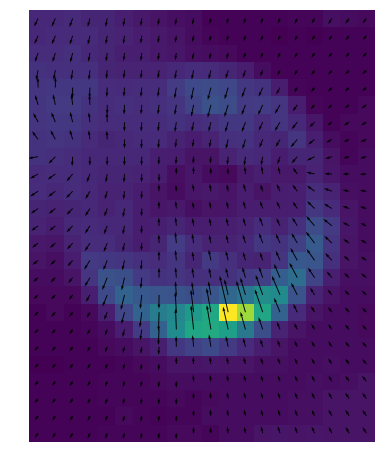

In [76]:
fig = plt.figure(frameon=False, figsize=(6,6))
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

n, m = Axx.shape 
X, Y = np.mgrid[0:n, 0:m]
T = .5 * np.arctan2(2 * Axy, Ayy-Axx)
R = np.ones((gamma_adjusted.shape)) * gamma_adjusted
U, V = R * (-np.cos(T)), R * (np.sin(T))
_ = plt.quiver(U, V, linewidths=2)
_ = plt.imshow(gamma_adjusted)
#plt.savefig("../thesis/images/struct_tensor_result_2.png")

label: fig:struct_tensor_result

In [77]:
gamma_adjusted = exposure.adjust_gamma(im, 0.1)
gamma_adjusted = np.flip(gamma_adjusted.T, axis=0)
Axx, Axy, Ayy = utils.my_structure_tensor(gamma_adjusted, smooth_mask)

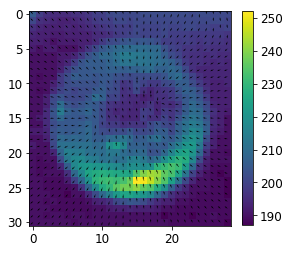

In [78]:
fig = plt.figure(frameon=False, figsize=(4,4))

n, m = Axx.shape 
X, Y = np.mgrid[0:n, 0:m]
T = .5 * np.arctan2(2 * Axy, Ayy-Axx)
R = np.ones((gamma_adjusted.shape)) * gamma_adjusted
U, V = R * (-np.cos(T)), R * (np.sin(T))
_ = plt.quiver(U, V, linewidths=2)
_ = plt.imshow(gamma_adjusted)
plt.colorbar(fraction=0.048)
#plt.savefig("../thesis/images/struct_tensor_orientation.png")

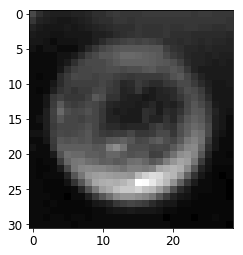

In [79]:
fig = plt.figure(frameon=False, figsize=(4,4))
plt.imshow(gamma_adjusted, cmap="gray")
#plt.savefig("../thesis/images/struct_tensor_original.png")

In [80]:
l1, l2 = feature.structure_tensor_eigvals(Axx, Axy, Ayy)

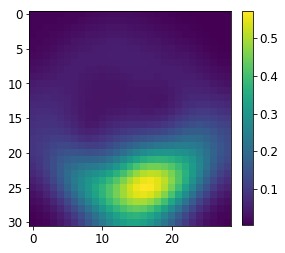

In [81]:
plt.figure(figsize=(4,4))
plt.imshow(l1)
plt.colorbar(fraction=0.048)
#plt.savefig("../thesis/images/larger_ev.png")

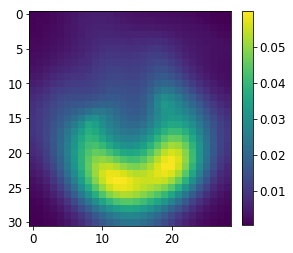

In [82]:
plt.figure(figsize=(4,4))
plt.imshow(l2)
plt.colorbar(fraction=0.048)
#plt.savefig("../thesis/images/smaller_ev.png")

# 5.2.2 Signal extraction

In [89]:
plat = platform.system()
if plat == "Windows":
    render_dir = "../renders/"
else:
    render_dir = "../ring_ansatz/renders/"
print(plat)

Windows


In [90]:
pickle_paths = []
png_path = []
for filename in os.listdir(render_dir):
    if filename.endswith(".pickle"):
        pickle_paths.append(os.path.join(render_dir, filename))
        
        
            
    elif filename.endswith(".png"):
        png_path.append(os.path.join(render_dir, filename))
        
        
        


In [91]:
pickle_paths.sort()
png_path.sort()

In [92]:
radii = []
profiles = []
for pp in pickle_paths:
    with open(pp, "rb") as handle:
        lb = pickle.load(handle)
        radii.append((lb[0]["xmax"] - lb[0]["xmin"]) / 2)
for pp in png_path:
    rd = cv2.imread(pp, 0)
    profiles.append(rd[20])

In [93]:
from scipy.signal import argrelextrema
from scipy.ndimage.filters import gaussian_filter1d

In [94]:
smoothed_profiles = [gaussian_filter1d(profile, sigma=1) for profile in profiles]

In [95]:
peaks = [argrelextrema(sp, np.greater)[0] for sp in smoothed_profiles]


In [96]:
dist_peaks = [np.nan] * len(peaks)
for idx, p in enumerate(peaks):
    if p.shape==(2,):
        dist_peaks[idx] = np.abs(p[1] - p[0])

In [97]:
invalid = np.isnan(dist_peaks)
valid = np.invert(invalid)

In [98]:
radii = np.asarray(radii)
dist_peaks = np.asarray(dist_peaks)
popt, _ = curve_fit(lin, radii[valid], dist_peaks[valid])

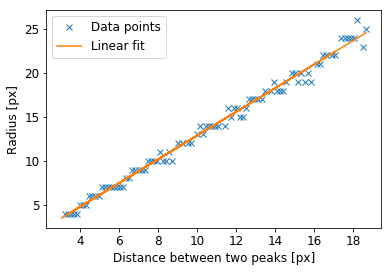

In [99]:
plt.figure()
plt.plot(radii, dist_peaks, 'x', label="Data points")
plt.plot(radii, lin(radii, *popt), label="Linear fit")
plt.xlabel("Distance between two peaks [px]")
plt.ylabel("Radius [px]")
plt.legend()
#plt.savefig("../thesis/graphs/peak_distance_radius_fit.png")

# 4.4 Measurement result

In [100]:
aq_low_1 = cv2.imread("../thesis/images/aquarium_result_sat_small.png", 0)
aq_low_2 = cv2.imread("../thesis/images/aquarium_result_sat_samll_2.png", 0)

In [115]:
large_aq_low_1 = imresize(aq_low_1, 400, interp="nearest")

In [128]:
from scipy.misc import imresize
def imresize_save(filename, suffix="_large.png", size=400):
    small_im = cv2.imread(filename, 0)
    large_filename = filename + suffix
    large_im = imresize(small_im, size, interp="nearest")
    cv2.imwrite(large_filename, large_im)

In [129]:
filenames = [f for f in os.listdir("../thesis/images/") if f.startswith("aquarium_result")]

In [130]:
"""
for fn in filenames:
    fn_path = os.path.join("../thesis/images/", fn)
    imresize_save(fn_path)
"""

In [131]:
#imresize_save("../thesis/images/aq_result_surf_small_2.png")

# 5.4.1. Depth of field

In [8]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_35_calib_DoF" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_35_calib_DoF/"

cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

for file in filenames:
    if file.endswith("2.bmp"):
        img = cv2.imread(os.path.join(calib_dir, file), 0)
        cim.append(img)
    elif file.endswith("1.bmp"):
        img = cv2.imread(os.path.join(calib_dir, file), 0)
        bgim.append(img)

In [9]:
# load stable data
stable_img_dir = "data/stable_redlit/"
filenames = [fn for fn in os.listdir(stable_img_dir) if fn.endswith(".png")]

In [10]:
stbl = [cv2.imread(os.path.join(stable_img_dir, fn),0) 
        for fn in filenames]

In [11]:
HORIZONTAL = Point(1, 0)
LINE_LEN = 20
calib_bubbles = [ 
    CalibBubble(Line(direction=HORIZONTAL, point=Point(842, 132)), radius=80, frame_start=1, frame_end=48),
    CalibBubble(Line(HORIZONTAL, Point(912, 470)), 54, 8, 36),
    CalibBubble(Line(HORIZONTAL, Point(968, 665)), 19, 24, 38),
    CalibBubble(Line(HORIZONTAL, Point(1023, 636)), 15, 36, 44),
    CalibBubble(Line(HORIZONTAL, Point(1103, 723)), 6, 43, 47),
    CalibBubble(Line(HORIZONTAL, Point(1127, 744)), 22, 42, 48)
    
]

In [12]:
curves = []
for cb in calib_bubbles:
    cb_curve = []
    for f in np.arange(cb.frame_start, cb.frame_end):
        fit_line = stbl[f][cb.line.point.y, int(cb.line.point.x-LINE_LEN/2):int(cb.line.point.x+LINE_LEN/2)]
        (amp, mu, sigma), _ = curve_fit(gauss, 
                                       np.arange(0, len(fit_line)),
                                       fit_line)
        cb_curve.append(np.abs(sigma))
    curves.append(cb_curve)
        

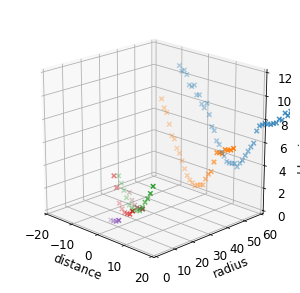

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')
for cu, cb in zip(curves, calib_bubbles):
    x = np.arange(0, len(cu)) -np.argmin(cu)
    y = cu
    ax.scatter(x,y, zs=cb.radius, zdir='y', label='curve in (x,z)', marker='x')
    
ax.set_xlim(-20, 20)
ax.set_ylim(0, 60)
ax.set_zlim(0, 12)
ax.set_xlabel('distance')
ax.set_ylabel('radius')
ax.set_zlabel('blurriness')
ax.view_init(elev=20., azim=-45)

#fig.savefig("../thesis/images/dof_calibration_measurement.png")

In [14]:
def calib_func(x, m, b, a0, sigma):
    return np.abs(x) * m + a0 * np.exp(-x**2/sigma**2) + b

In [15]:
fit_res = []
pcov_res = []
for cu in curves:
    popt, pcov = curve_fit(calib_func, 
                          np.arange(0, len(cu)),
                          cu)
    fit_res.append(popt)
    pcov_res.append(pcov)

C:\Users\windis\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [16]:
def scaled_parab(input_tuple, b1, a2, a1, c):
    (x, z) = input_tuple
    x = np.asarray(x)
    z = np.asarray(z)
    y = (b1*z) + a2*x**2 + a1*x +c
    return y.ravel()

In [17]:
def paraboloid(input_tuple, a, b, c, d, e):
    (x,z) = input_tuple
    x = np.asarray(x)
    z = np.asarray(z)
    y = a*(x-b)**2 + c*(z-d) + e
    return y.ravel()

In [18]:
def parab(x, a2, a1, a0):
    x = np.asarray(x)
    return a2*x**2 + a1*x + a0

In [19]:
curves[0] = curves[0][10:30]

In [20]:
curves[1] = curves[1][0:20]

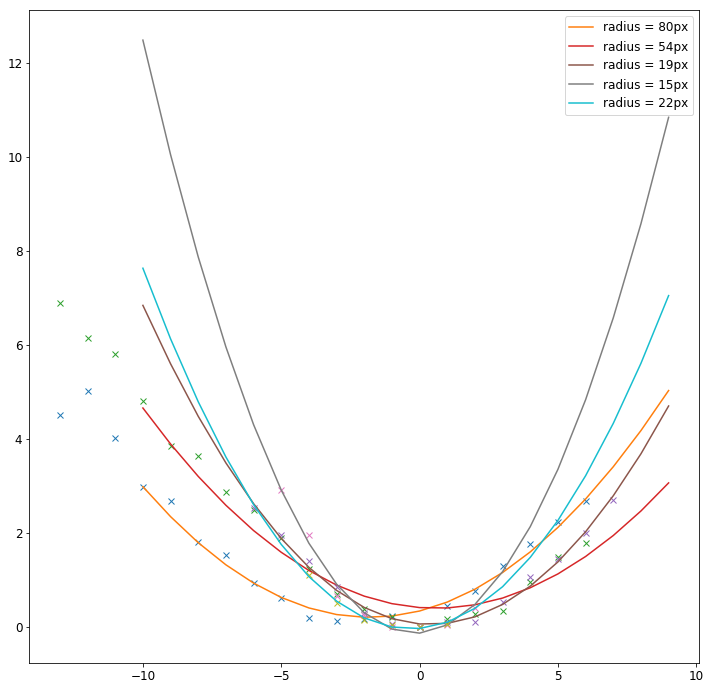

In [21]:
plt.figure(figsize=(12,12))
xfitdata = []
yfitdata = []
zfitdata = []
for cu, cb in zip(curves, calib_bubbles):
    if cb.radius != 6:
        xx = np.arange(0, len(cu)) - np.argmin(cu)
        xxfit = list(np.arange(-10, 10))
        popt, pcov = curve_fit(parab, xx, cu -min(cu))
        plt.plot(xx, cu-min(cu), 'x') 
        yyfit = list(parab(xxfit, *popt))
        plt.plot(xxfit, yyfit, label="radius = "+str(cb.radius) +"px")
        
        xfitdata += xxfit
        yfitdata += yyfit
        zfitdata += ([cb.radius]*len(xxfit))
        
plt.legend()

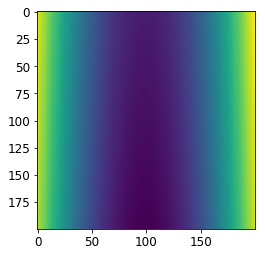

In [22]:
popt, pcov = curve_fit(scaled_parab, (xfitdata, zfitdata), yfitdata)

x = np.linspace(-20, 20, 200)
z = np.linspace(0, 90, 200)
x, z = np.meshgrid(x,z)
y = scaled_parab((x,z), *popt)# popt[0], popt[1], popt[2], popt[3])

plt.imshow(y.reshape(200,200))

In [23]:
popt

array([-0.02688192,  0.07090587,  0.02970268,  1.14543908])

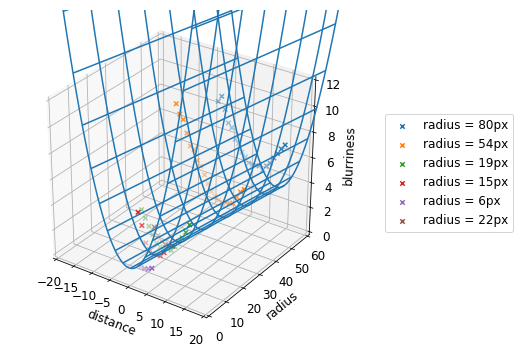

In [26]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(x, z, y.reshape(200,200), rstride=30, cstride=10)


for cu, cb in zip(curves, calib_bubbles):
    xraw = np.arange(0, len(cu)) -np.argmin(cu)
    yraw = cu
    ax.scatter(xraw,yraw, zs=cb.radius, zdir='y', label='radius = '+str(cb.radius) +"px", marker='x')
    


#ax.plot(xfitdata,yfitdata, zs=zfitdata, zdir='y', label='radius = '+str(cb.radius) +"px")
    
ax.set_xlim(-20, 20)
ax.set_ylim(0, 60)
ax.set_zlim(0, 12)
ax.set_xlabel('distance')
ax.set_ylabel('radius')
ax.set_zlabel('blurriness')
ax.view_init(elev=30., azim=-55)
lgd = ax.legend(bbox_to_anchor=(1.1, .7))


fig.savefig("../thesis/images/dof_calibration_fit.png",bbox_inches='tight', bbox_extra_artists=(lgd,) )

# 2.5.5 Orientation and structure tensor

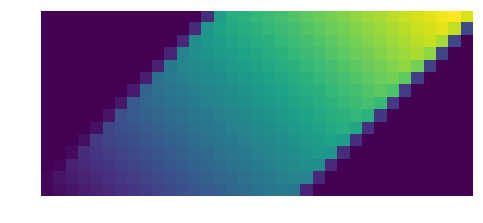

In [258]:
init_figure()
ox, oy = np.meshgrid(np.arange(0,35), np.arange(0,15))
orient = transform.rotate(ox, 45)
plt.imshow(orient)
#plt.imshow(imresize(orient, size=4))

In [259]:
tmp = cv2.imread("../thesis/images/aeolotron_result_raw.bmp", 0)

In [261]:
cv2.imwrite("../thesis/images/aeolotron_result_raw.png", tmp)

True

# Give figures some color

In [42]:
imlst = [
    "../thesis/images/aq_result_low_small_1.png",
    "../thesis/images/aq_result_low_small_2.png",
    "../thesis/images/aq_result_surf_small_1.png",
    "../thesis/images/aq_result_surf_small_2.png",
    "../thesis/images/aquarium_result_high_conc_1.png",
    "../thesis/images/aquarium_result_high_conc_2.png",
    "../thesis/images/aeolotron_result_small_1.png",
    "../thesis/images/aeolotron_result_small_2.png",
]

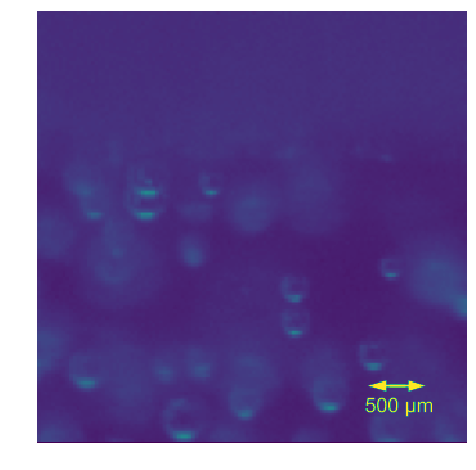

In [51]:
"""
for imname in imlst:
    im = cv2.imread(imname)
    init_figure()
    plt.imshow(im[:,:,2])
    plt.savefig(imname.replace("_GRAY", ""))
"""

In [65]:
imlst = [
    "../thesis/images/rad_calib_1.png",
    "../thesis/images/rad_calib_2.jpg",
    "../thesis/images/rad_calib_3.png",
    "../thesis/images/rad_calib_4.jpg",
]

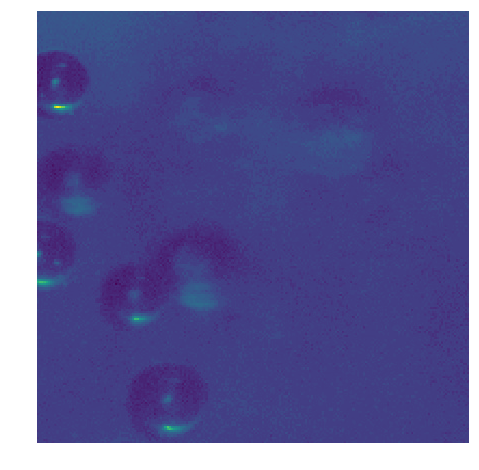

In [67]:
"""for imname in imlst:
    im = cv2.imread(imname, 0)
    filename = imname.replace(".jpg", "_COLOR.jpg")
    init_figure()
    plt.imshow(im)
    plt.savefig(filename)"""

In [68]:
imlst = [
    "../thesis/images/tracking_red.png",
]

In [74]:
im.max()

255

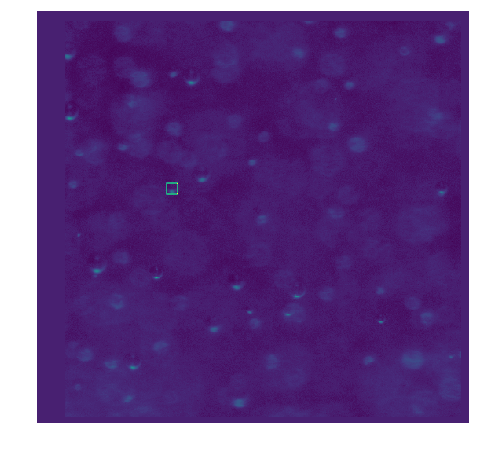

In [78]:
for imname in imlst:
    gim = cv2.imread(imname, 0)
    filename = imname.replace(".png", "_COLOR.png")
    init_figure()
    plt.imshow(gim[10:-10,:])
    plt.savefig(filename)